# Outliers

Informally, an **outlier** is a data value that is considered to be far from typical. There are various ways of deciding what "typical" means, and there is no one-size recommendation for all applications. Outliers can appear in data sets for numerous reasons: equipment failure, external effect, mistyping a value, using an extreme value to represent missing data, and so on. The trouble with outliers is that they can have an unreasonably strong influence on the statistics. 

Let's look at another data set, based on an fMRI experiment.

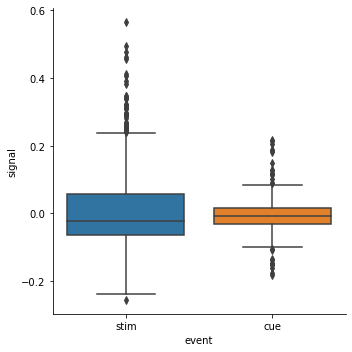

In [1]:
import pandas as pd
import seaborn as sns

fmri = sns.load_dataset("fmri")
sns.catplot(data=fmri,x="event",y="signal",kind="box")

The dots lying outside the whiskers in the plot may be considered outliers. They are determined by the quartiles. Let $Q_1$ and $Q_3$ be the first and third quartiles (i.e., 25% and 75% percentiles), and let $I=Q_3-Q_1$ be the interquartile range (IQR). Then $x$ is an outlier value if

$$ 
x < Q_1 - 1.5I \text{ or } x > Q_3 + 1.5I.
$$

For normal distributions, values more than twice the standard deviation $\sigma$ from the mean might be declared to be outliers; this would exclude 5% of the values, on average. A less aggressive criterion is to allow a distance of $3\sigma$, which excludes only about 0.3% of the values. The IQR criterion above corresponds to about $2.7\sigma$ in the normal case.


## Removing outliers

It is well known that the mean is more sensitive to outliers than the median is. 

```{prf:example}
The values $1,2,3,4,5$ have a mean and median both equal to 3. If we change the largest value to be a lot larger, say $1,2,3,4,1000$, then the mean changes to 202. But the median is still 3!
```

Let's use IQR to remove outliers from the fmri data set. We do this by creating a Boolean-valued series indicating which rows of the frame represent outliers within their group.

In [2]:
import numpy as np
def isoutlier(x):
    Q1 = x.quantile(.25)
    Q3 = x.quantile(.75)
    I = Q3-Q1
    return np.logical_or( x < Q1-1.5*I, x > Q3+1.5*I )

outs = fmri.groupby("event")["signal"].transform(isoutlier)
fmri[outs]["event"].value_counts()

stim    40
cue     26
Name: event, dtype: int64

You can see above that there are 66 outliers. To negate the outlier indicator, we can use `~outs` as a row selector.

In [3]:
cleaned = fmri[~outs]

The median values are barely affected by the omission of the outliers.

In [4]:
print("medians with outliers:")
print(fmri.groupby("event")["signal"].median())
print("\nmedians without outliers:")
print(cleaned.groupby("event")["signal"].median())

medians with outliers:
event
cue    -0.008871
stim   -0.022202
Name: signal, dtype: float64

medians without outliers:
event
cue    -0.009006
stim   -0.028068
Name: signal, dtype: float64


The means show much greater change.

In [5]:
print("means with outliers:")
print(fmri.groupby("event")["signal"].mean())
print("\nmeans without outliers:")
print(cleaned.groupby("event")["signal"].mean())

means with outliers:
event
cue    -0.006669
stim    0.013748
Name: signal, dtype: float64

means without outliers:
event
cue    -0.008243
stim   -0.010245
Name: signal, dtype: float64


For the "stim" case in particular, the mean value changes by almost 200%, including a sign change. (Relative to the standard deviation, it's closer to a 20% change.)